## Blockage Masks and Ellipsoidal Field of Views in Bepicolombo

This is a Python Jupyter Notebook to illustrate how to visualize the blockage mask due to the MPO structure for a sensor and how to project an ellipsoidal field of view. 

First thing we will do is indicate that we want the Python package matplotlib to be output in the notebook and to import the SpiceyPy package to use SPICE. We also ensure that project_path module is include, this will allow us get access to common packages and resources

In [1]:
from project_path import data_path

import spiceypy as cspice
import matplotlib.pyplot as plt
import os
import numpy as np
from tqdm import tqdm

Module path /Users/randres/git/spice/ess-jupyternb/src loaded
Using data_path: /Users/randres/git/spice/ess-jupyternb/data


We will setup the kernel set for the spice library, that will be used along the notebook

In [2]:
cspice.kclear()
cspice.furnsh('/Users/randres/git/spice/bepicolombo/kernels/mk/bc_plan.tm')
# cspice.furnsh(
#     os.path.join(data_path, 'test', 'bc_mpo_sc_bus_v03_hga_nosixs.bds'))

### FOV projection

Some auxiliary function definitions:
* get_coords 
* ellipse3d

In [3]:
def get_coords(vector, method='reclat', body='MERCURY'):
    """
    :param vector: vector position
    :param method: SPICE method (reclat, recsph, recpgr)
    :param body: Name of the body to be used in case of planetographic coordinates computation
    :returns a vector [lon,lat,distance] or associated (values in degrees)
    """
    if method == 'reclat':
        distance, lon, lat = cspice.reclat(vector)
        out = [lon*180/np.pi, lat*180/np.pi, distance]
    elif method == 'recsph':
        distance, colat, lon = cspice.recsph(vector)
        out = [lon*180/np.pi, 90-colat*180/np.pi, distance]
    elif method == 'recpgr':
        radii = cspice.bodvrd(body, 'RADII', 3)
        f = (radii[0]-radii[3]) / radii[0]
        lon, lat, distance = cspice.recpgr(body, vector, radii[0], f)
        out = [lon*180/np.pi, lat*180/np.pi, distance]
    return out


def ellipse3d(bs, bd, npts=100):
    """
    Compute the ellipse points of a given SPICE ellipse (made of a center and 2 generating vectors)

    vec = center + cos(theta) * vector1 + sin(theta) * vector2

    :param bs: Boresight position (from SPICE)
    :param bd: Bound vectors position (from SPICE)
    :return: X, Y, Z coordinates of the ellipse points in the frame
    """
    theta = np.linspace(-np.pi, np.pi, npts)
    c = bs  # boresight
    anga = cspice.vsep(bs, bd[0])
    angb = cspice.vsep(bs, bd[1])
    v1mag = np.linalg.norm(bs) * np.tan(anga)  # boresight - bound[0] = semi-major axis
    v2mag = np.linalg.norm(bs) * np.tan(angb)  # boresight - bound[1] = semi-minor axis
    v1 = bd[0] - np.dot(bd[0], c)/np.dot(c, c) * c
    v2 = bd[1] - np.dot(bd[1], c)/np.dot(c, c) * c
    v1 = v1/np.linalg.norm(v1) * v1mag
    v2 = v2/np.linalg.norm(v2) * v2mag
    x = []
    y = []
    z = []
    for t in theta:
        el = c + np.cos(t) * v1 + np.sin(t) * v2
        x.append(el[0])
        y.append(el[1])
        z.append(el[2])
    return x, y, z

The following function generates a matplotlib scatter plot that shows the projection of the ellipsoidal field of view 

In [4]:

def plot_ellipsoidal_fov(detector, color, label, et, base_frame='MPO_SIXS_SU'):
    """_summary_

    Args:
        detector (str): Detector name
        color (str): color used in the plot
        label (str): _description_
        et (float): ephemeris time
        base_frame (str, optional): frame name of the structure base of the sensor. 
        Defaults to 'MPO_SIXS_SU'.
    """    
    camera_id = cspice.bodn2c(detector)
    (shape, frame, bsight, vectors, bounds) = cspice.getfov(camera_id, 100)
    rot = cspice.pxform(frame, base_frame, et)

    x, y, z = ellipse3d(bsight, bounds)
    ellipse_coord = [[x[j], y[j], z[j]] for j in range(len(x))]
    ellipse_coord.append(bsight)
    ellipse_coord = np.asarray(ellipse_coord)
    ellipse_coords = [cspice.mxv(rot, el) for el in ellipse_coord]
    ellipse_coord = ellipse_coords
    fov_az = []
    fov_el = []
    for fov in ellipse_coord:
        
        tmp = get_coords(fov, method='reclat')
        fov_az.append(tmp[0])
        fov_el.append(tmp[1])

    inds = np.array(fov_az).argsort()
    fov_az = np.array(fov_az)[inds].tolist()
    fov_el = np.array(fov_el)[inds].tolist()

    plt.scatter(fov_az, fov_el, color=color, label=label, alpha=0.8)

    return


As a practical sample, we will plot the SIXS-X FOVs. The projection is time dependant in the case of an articulated FOV, so we pass an ephemeris time to set it up.

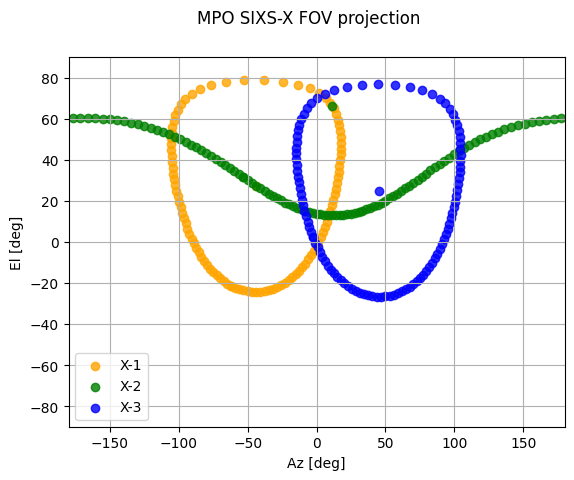

In [5]:
et = cspice.utc2et('2021-06-14T00:00:15.656')
plot_ellipsoidal_fov(detector = 'MPO_SIXS-X-1', color = 'orange', label='X-1', et=et)
plot_ellipsoidal_fov(detector = 'MPO_SIXS-X-2', color = 'green', label='X-2', et=et)
plot_ellipsoidal_fov(detector = 'MPO_SIXS-X-3', color = 'blue', label='X-3', et=et)
plt.suptitle('MPO SIXS-X FOV projection')
plt.xlim([-180, 180])
plt.ylim([-90, 90])
plt.xlabel('Az [deg]')
plt.ylabel('El [deg]')
plt.grid()
plt.legend()
plt.show()

### Mask blockage calculation
The next function uses raytracing checks on the dsk storing the MPO 3D model to obtain the blockage mask from sensor position.


In [6]:
def mask_blockage(sensor, color, et, spacecraft='MPO_SPACECRAFT', dsk_structures=[-121000], ang_prec=0.5):
    el_angles = np.arange(-90, 91, ang_prec)
    az_angles = np.arange(-180, 181, ang_prec)
    output = []
    output_b = []
    for el in tqdm(el_angles):
        for az in az_angles:
            r = cspice.spkpos(sensor, et, spacecraft, 'NONE', spacecraft)[0]
            d = cspice.azlrec(1, np.deg2rad(az), np.deg2rad(el), True, True)

            xarray, flag = cspice.dskxv(False, spacecraft, dsk_structures, et, spacecraft,
                             [r], [d])
            if flag == True:
                blocked = 1
                output_b.append([blocked, el, az, et])
            else:
                blocked = 0
            output.append([blocked, el, az, et])
    output_b = np.asarray(output_b)
    plt.scatter(-output_b[:, 2], -output_b[:, 1], color=color, alpha=0.2, edgecolor='none')
    return

In the next sample, the fov and mask blockage for SIXS-X-1

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 362/362 [00:17<00:00, 21.13it/s]


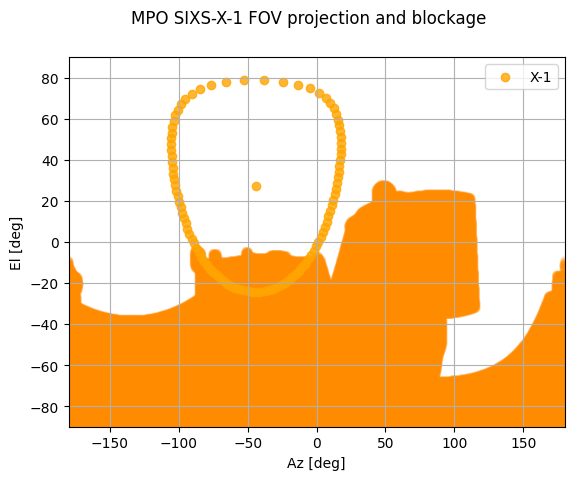

In [7]:
et = cspice.utc2et('2021-06-14T00:00:15.656')
mask_blockage('MPO_SIXS-X-1', 'darkorange', et)
plot_ellipsoidal_fov(detector = 'MPO_SIXS-X-1', color = 'orange', label='X-1', et=et)
plt.suptitle('MPO SIXS-X-1 FOV projection and blockage')
plt.xlim([-180, 180])
plt.ylim([-90, 90])
plt.xlabel('Az [deg]')
plt.ylabel('El [deg]')
plt.grid()
plt.legend()
plt.show()